# Test Bayesian Optimisation - Tree-structured Parzen Estimator as a hyperparameter optimiser for the ANN-CloudClassifier

Import necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from itertools import product
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import datasets, transforms
from hyperopt import fmin, tpe, hp, Trials

from sklearn import metrics
from sklearn.metrics import f1_score

import netCDF4 as nc
from scipy.ndimage import zoom

npyPath = "skogsstyrelsen-data"
ncPath = "skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria"
npyFiles =["skogs_json_test.npy", "skogs_json_train.npy", "skogs_json_val.npy"]

Define classes

In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        """
        Args:
            features (numpy array or torch.Tensor): Multi-band satellite images (shape: N x C x H x W).
            labels (numpy array or torch.Tensor): Binary labels (0 or 1).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert to tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]  # Get image (shape: C x H x W)
        label = self.labels[idx]    # Get corresponding label

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

In [3]:
# Define the CNN model dynamically
class CNN(nn.Module):
    def __init__(self, num_conv_layers, num_fc_layers):
        super(CNN, self).__init__()
        layers = []
        in_channels = 3
        out_channels = 64

        # Add convolutional layers
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        layers.append(nn.Flatten())

        # Compute flattened feature size (assuming input size 22x22)
        fc_input_size = (22 // (2 ** num_conv_layers)) ** 2 * out_channels

        # Add fully connected layers
        fc_layers = []
        fc_units = [fc_input_size, 128, 64, 32][:num_fc_layers] + [2]
        for i in range(len(fc_units) - 1):
            fc_layers.append(nn.Linear(fc_units[i], fc_units[i + 1]))
            if i < len(fc_units) - 2:  # No activation on last layer
                fc_layers.append(nn.ReLU())
                fc_layers.append(nn.Dropout(0.5))
        
        layers.extend(fc_layers)
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

Define helper functions

In [4]:
def npy_loader():
    
    
    # Initialize data_list outside the loop
    data_list = []

    # Load and print contents of each file
    for file_name in npyFiles:
        full_path = os.path.join(npyPath, file_name)  # Include folder path
        if os.path.exists(full_path):  # Ensure file exists
            data = np.load(full_path, allow_pickle=True)  # Load the .npy file
            # Extract 'ValideringsobjektBildId' and 'MolnDis' from each JSON line
            if isinstance(data, np.ndarray) and data.size > 0 and isinstance(data[0], dict):
                for item in data:
                    valideringsobjekt_bild_id = item.get('ValideringsobjektBildId', 'N/A')
                    moln_dis = item.get('MolnDis', 'N/A')
                    # Add to a list of lists
                    data_list.append([valideringsobjekt_bild_id, moln_dis])
            else:
                print(f"File {file_name} does not contain the expected JSON data.")
        else:
            print(f"File {file_name} does not exist.")
    print(f"Loaded {len(data_list)} items.")
    return data_list

In [5]:
def combine_bands(data_list):
    bands = ['b02','b03', 'b04']
    target_shape = (22, 22)  # Ensure uniform size

    features = []
    labels = []

    for item in data_list:
        file_id, label = item
        file_path = os.path.join(ncPath, f'skgs_{file_id}.nc')

        try:
            with nc.Dataset(file_path, 'r') as dataset:
                resampled_bands = []

                for band in bands:
                    if band in dataset.variables:
                        band_data = dataset.variables[band][0, :, :]  # Extract first time slice
                        band_data = np.nan_to_num(band_data, nan=0.0)  # Replace NaNs with 0

                        # We use edge padding
                        #
                        if band_data.shape != target_shape:
                            print(f"Padding {file_id}: {band_data.shape} → {target_shape}")
                            pad_width = get_padding(band_data.shape, target_shape)
                            #
                            band_data = np.pad(band_data, pad_width, mode='edge')
                        

                        resampled_bands.append(band_data)
                    else:
                        print(f"Warning: {band} not found in {file_path}")
                        resampled_bands.append(np.zeros(target_shape))  # Default empty band

                # Ensure we always have (4, 21, 21)
                combined_bands = np.stack(resampled_bands, axis=0)  # (C, H, W)
                print(f"Final processed shape: {combined_bands.shape}")  # Debugging

                features.append(combined_bands)
                labels.append(label)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    print(f"Processed {len(features)} samples.")

    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.int64)

# Compute the padding required for each dimension
def get_padding(band_shape, target_shape):
    return [(0, max(0, target_shape[i] - band_shape[i])) for i in range(len(target_shape))]

In [6]:
def calculate_mean_std(train_dataset):
    
    mean_values = []
    std_values = []
    
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    
    for imgs, _ in train_loader:
        num_channels = imgs.shape[1]
        for channel in range(num_channels):
            num_pixels_per_channel = imgs.shape[0] * imgs.shape[2] * imgs.shape[3] # number of images * image height * image width
            mean = imgs[:,channel,:,:].sum() / num_pixels_per_channel
            std = torch.sqrt((((imgs[:,channel,:,:] - mean) ** 2).sum()) / num_pixels_per_channel)
            print("channel: ", channel, "mean: ", mean.item(), "std: ", std.item())
            mean_values.append(mean.item())
            std_values.append(std.item())

    return mean_values, std_values

In [7]:
def plot_confusion_matrix(all_labels = None, all_predictions = None, class_labels = [0, 1]):
    
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
    
    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)

    print(cm)

    # Set up the figure with a proper aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    # Adjust layout for a cleaner look
    plt.tight_layout()
    plt.show()

Methods for model

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    
    train_loss_array = []
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss/len(train_loader)
        train_loss_array.append(training_loss)

        # Validation
        val_loss, val_acc, _, _ = test_model(val_loader, model)

        # Save the best model based on validation accuracy
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'cloudclass.pth')


        #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"Best validation accuracy: {best_accuracy:.2f}%")
    
    return model, best_accuracy


def test_model(loader, model = None, criterion = None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        # Load the best model weights
        if model == None:
            model.load_state_dict(torch.load('cloudclass.pth'))

        if criterion == None:
            criterion = nn.CrossEntropyLoss()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            all_labels.extend(labels)
            all_preds.extend(predicted)
        
        loss = running_loss/len(loader)
        accuracy = 100 * correct / total
            
    return loss, accuracy, np.array(all_labels), np.array(all_preds)

---

Preparation of data

Loaded 432 items.
Padding 765861ec-42c7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 765861ec-42c7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 765861ec-42c7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Final processed shape: (3, 22, 22)
Padding 1657a784-3ac7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 1657a784-3ac7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Padding 1657a784-3ac7-ed11-9174-005056a6f472: (21, 21) → (22, 22)
Final processed shape: (3, 22, 22)
Padding ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (22, 22)
Padding ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (22, 22)
Padding ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (22, 22)
Final processed shape: (3, 22, 22)
Padding 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (22, 22)
Padding 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (22, 22)
Padding 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (22, 22)
Final processed shape: (3, 22, 22)
Padding 50b88b11-3ec7-ed11-9174-005056a6f472: (21,

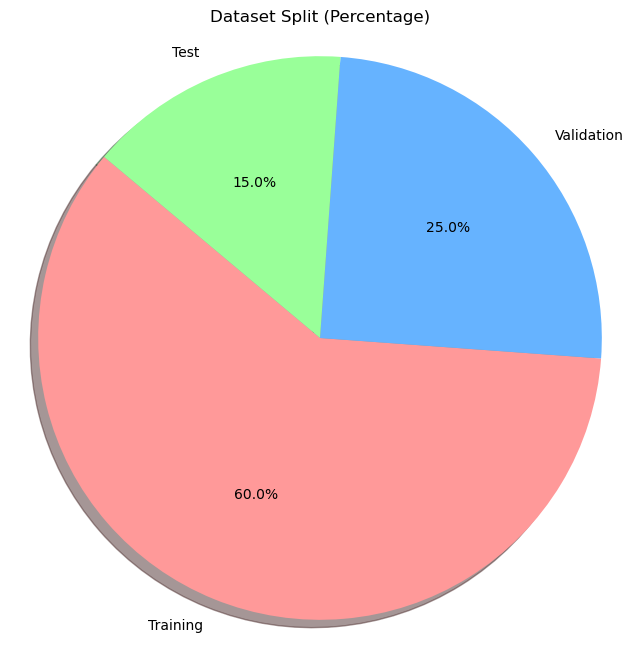

In [9]:
features, labels = combine_bands(npy_loader(),)

print(features.shape, labels.shape)


#dataset_transform = SatelliteDataset(features, labels, transform=transform)
dataset = SatelliteDataset(features, labels)


# Random split of the data
validation_split = 0.25
train_split = 0.6
test_split = 0.15

# Define the sizes for each split
train_size = int(train_split * len(dataset))
val_size = int(validation_split * len(dataset))
test_size = len(dataset) - train_size - val_size


# Set random seed for reproducibility
generator = torch.Generator().manual_seed(31)

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Calculate the mean and std of the training set -> used to normalize train, val and testset
mean, std = calculate_mean_std(train_dataset)

# Get all cloud images from the training set
# Get all cloud images (label 1) from the training set
cloudy_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]
cloudy_dataset = torch.utils.data.Subset(train_dataset, cloudy_indices)

# Clouddataset
transformCloud = transforms.Compose([
    transforms.Normalize(mean=mean, std=std)  # Normalize using calculated mean and std
])

# Define the transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping
    transforms.RandomRotation([0, 270]),  # Random rotation up to 40 degrees
    transforms.Normalize(mean=mean, std=std)  # Normalize using calculated mean and std
])

transform_normalize = transforms.Compose([
    transforms.Normalize(mean=mean, std=std)  # Normalize values to [0, 1]
])

cloudy_dataset.dataset.transform = transformCloud
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform_normalize
test_dataset.dataset.transform = transform_normalize

# Combine the datasets
#train_dataset = ConcatDataset([train_dataset, cloudy_dataset])


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Function to plot images from datasets




print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))



# Pie chart of dataset splits
total_size = len(dataset)
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

train_percent = (train_size / total_size) * 100
val_percent = (val_size / total_size) * 100
test_percent = (test_size / total_size) * 100

# Pie chart of dataset splits using percentages
sizes = [train_percent, val_percent, test_percent]
labels = ['Training', 'Validation', 'Test']
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=140)
plt.title('Dataset Split (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Bayesian Optimisation

In [10]:
# Define the search space
search_space = {
    'num_conv_layers': hp.choice('num_conv_layers', [2, 3, 4]),
    'num_fc_layers': hp.choice('num_fc_layers', [2, 3, 4]),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3), # default 1e-3
    'lr_decay': hp.uniform('lr_decay', 0, 1e-3), # default 0
    'num_epochs': hp.choice('num_epochs', [200, 300])
}

In [11]:
# Define the objective function
def objective(params):
    model = CNN(num_conv_layers=params['num_conv_layers'], num_fc_layers=params['num_fc_layers'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['lr_decay'])
    
    model, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, params['num_epochs'])
    return -val_acc  # Negative because hyperopt minimizes

In [12]:
# Run the optimization
trials = Trials()
best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=60, trials=trials)
print("Best Parameters:", best_params)

Best validation accuracy: 92.31%                      
Best validation accuracy: 92.31%                                               
Best validation accuracy: 93.85%                                               
Best validation accuracy: 92.31%                                                
Best validation accuracy: 89.23%                                                
Best validation accuracy: 95.38%                                                
Best validation accuracy: 90.77%                                                
Best validation accuracy: 90.77%                                                
Best validation accuracy: 95.38%                                                
Best validation accuracy: 95.38%                                                
Best validation accuracy: 93.85%                                                 
Best validation accuracy: 93.85%                                                 
Best validation accuracy: 92.31%                      

In [13]:
# 'num_conv_layers': hp.choice('num_conv_layers', [2, 3, 4]),
# 'num_fc_layers': hp.choice('num_fc_layers', [2, 3, 4]),
# 'num_epochs': hp.choice('num_epochs', [200, 300]

arr_conv_layers = [2, 3, 4]
arr_fc_layers = [2, 3, 4]
arr_epochs = [200, 300]

Best validation accuracy: 95.38%
Test Accuracy: 92.31%
F1 score: 86.49%
[[44  2]
 [ 3 16]]


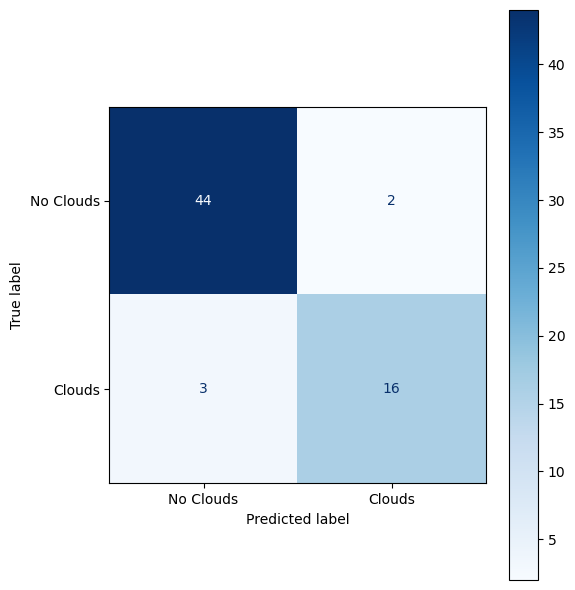

In [16]:
# Train final model with best parameters
best_model = CNN(num_conv_layers=arr_conv_layers[best_params['num_conv_layers']], num_fc_layers=arr_fc_layers[best_params['num_fc_layers']])
best_criterion = nn.CrossEntropyLoss()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['lr_decay'])

best_model,_ = train_model(best_model, best_criterion, best_optimizer, train_loader, val_loader, arr_epochs[best_params['num_epochs']])

test_loss, test_accuracy, all_labels, all_preds = test_model(test_loader, best_model, best_criterion)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("F1 score: {:.2f}%".format(f1_score(all_labels, all_preds) * 100))
plot_confusion_matrix(all_labels, all_preds, class_labels=['No Clouds', 'Clouds'])

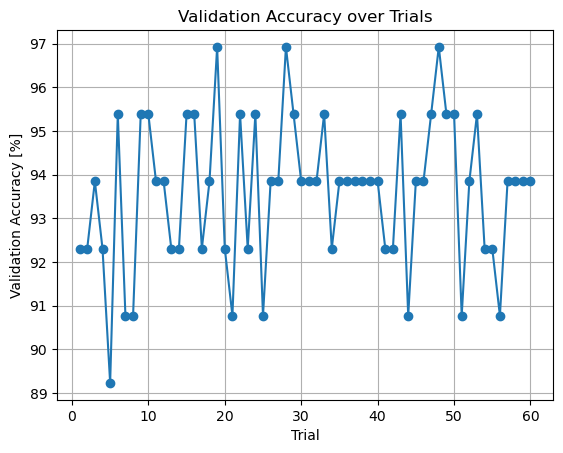

In [17]:
# Extract the accuracy from the trial information
losses = [-trial['result']['loss'] for trial in trials.trials]

# Plot the accuracy over the trials
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Trial")
plt.ylabel("Validation Accuracy [%]")
plt.title("Validation Accuracy over Trials")
plt.grid()
plt.show()